In [1]:
# -*- coding: utf-8 -*-
from pathlib import Path
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from spikeinterface.preprocessing import detect_bad_channels
from spikeinterface_gui import run_mainwindow
import spikeinterface.full as si
import spikeinterface.sorters as ss
import spikeinterface.preprocessing as spre
import spikeinterface.widgets as sw
import pandas as pd
from spikeinterface.exporters import export_to_phy
from spikeinterface.curation import remove_duplicated_spikes, remove_redundant_units





In [2]:
# readdata
# === Read SpikeGLX folder only (AP for spikes, NIDQ for TTL) ===

SPIKEGLX_FOLDER = r"E:/testephys"  # spikeglx folder
streams, _ = si.get_neo_streams('spikeglx', SPIKEGLX_FOLDER)
print("streams:", streams)
AP_STREAM = next(n for n in streams if n.endswith(".ap"))
print("AP stream:", AP_STREAM)

rec_ap = si.read_spikeglx(SPIKEGLX_FOLDER, stream_name=AP_STREAM, load_sync_channel=False)
print(rec_ap)
print("AP Fs:", rec_ap.sampling_frequency, "Hz | #ch:", rec_ap.get_num_channels(),
      "| dur(s):", round(rec_ap.get_total_duration(), 3))
print("First 10 AP ch IDs:", rec_ap.get_channel_ids()[:10])

# NIDAQ for TTL
NIDQ_STREAM = next((n for n in streams if "nidq" in n.lower()), None)
if NIDQ_STREAM is None:
    print("No NIDQ stream found.")
    rec_nidq = None
else:
    rec_nidq = si.read_spikeglx(SPIKEGLX_FOLDER, stream_name=NIDQ_STREAM)
    print("NIDQ stream:", NIDQ_STREAM)
    print(rec_nidq)
    print("NIDQ Fs:", rec_nidq.sampling_frequency, "Hz | #ch:", rec_nidq.get_num_channels(),
          "| dur(s):", round(rec_nidq.get_total_duration(), 3))



streams: ['imec0.ap', 'nidq', 'imec0.lf', 'imec0.ap-SYNC', 'imec0.lf-SYNC']
AP stream: imec0.ap
SpikeGLXRecordingExtractor: 384 channels - 30000.505021 Hz - 1 segments - 170,689,039 samples 
                            5,689.54s (1.58 hours) - int16 dtype - 122.09 GiB
AP Fs: 30000.505020920504 Hz | #ch: 384 | dur(s): 5689.539
First 10 AP ch IDs: ['imec0.ap#AP0' 'imec0.ap#AP1' 'imec0.ap#AP2' 'imec0.ap#AP3'
 'imec0.ap#AP4' 'imec0.ap#AP5' 'imec0.ap#AP6' 'imec0.ap#AP7'
 'imec0.ap#AP8' 'imec0.ap#AP9']
NIDQ stream: nidq
SpikeGLXRecordingExtractor: 9 channels - 10593.500000 Hz - 1 segments - 60,272,088 samples 
                            5,689.53s (1.58 hours) - int16 dtype - 1.01 GiB
NIDQ Fs: 10593.5 Hz | #ch: 9 | dur(s): 5689.535


,x,y,contact_shapes,width,shank_ids,contact_ids
0,0.0,0.0,square,12.0,,e0
1,103.0,0.0,square,12.0,,e1
2,0.0,20.0,square,12.0,,e2
3,103.0,20.0,square,12.0,,e3
4,0.0,40.0,square,12.0,,e4


列： ['x', 'y', 'contact_shapes', 'width', 'shank_ids', 'contact_ids']
y范围 (µm): 0.0 → 3820.0
通道数： 384
locations shape: (384, 2)


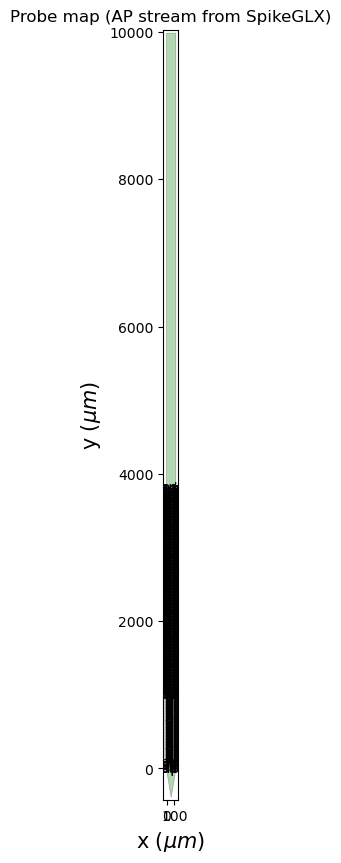

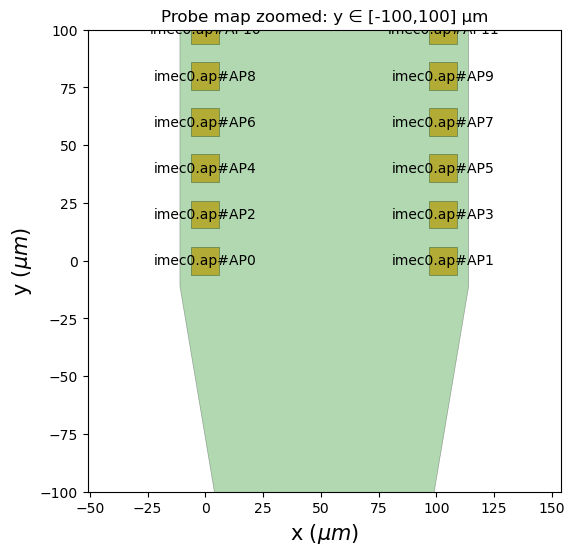

In [3]:
#visualization Probe:
probe = rec_ap.get_probe()
df = probe.to_dataframe()
display(df.head())
print("列：", list(df.columns))
print("y范围 (µm):", float(df["y"].min()), "→", float(df["y"].max()))
print("通道数：", rec_ap.get_num_channels())
print("locations shape:", rec_ap.get_channel_locations().shape)

fig, ax = plt.subplots(figsize=(9, 10))
sw.plot_probe_map(rec_ap, ax=ax, with_channel_ids=True)
ax.set_title("Probe map (AP stream from SpikeGLX)")
plt.show()


#part of probe
y0, y1 = -100, 100
fig, ax = plt.subplots(figsize=(9, 6))
sw.plot_probe_map(rec_ap, ax=ax, with_channel_ids=True)
ax.set_ylim(y0, y1)
ax.set_title(f"Probe map zoomed: y ∈ [{y0},{y1}] µm")
plt.show()


In [4]:
# preprocessing: bandpass → phase_shift → remove bad channels → CAR
def _has_prop_safe(recording, key: str) -> bool:
    try:
        return key in recording.get_property_keys()
    except Exception:
        try:
            recording.get_property(key)
            return True
        except Exception:
            return False

rec_ap_bp = spre.bandpass_filter(rec_ap, freq_min=300, margin_ms=5.0)

need_ps = _has_prop_safe(rec_ap_bp, "inter_sample_shift") or _has_prop_safe(rec_ap, "inter_sample_shift")
if need_ps:
    try:
        rec_ap_ps = spre.phase_shift(rec_ap_bp)
        print("Applied phase_shift (inter_sample_shift).")
    except Exception as e:
        print("phase_shift skipped due to error:", e)
        rec_ap_ps = rec_ap_bp
else:
    rec_ap_ps = rec_ap_bp
    print("No inter_sample_shift; skip phase_shift.")

bad_ids, ch_labels = detect_bad_channels(
    recording=rec_ap_ps,
    method='coherence+psd'  
)
if len(bad_ids):
    print("Bad channels detected:", bad_ids)
    try:
        rec_ap_ps_good = rec_ap_ps.remove_channels(bad_ids) 
    except Exception:
        rec_ap_ps_good = rec_ap_ps
        print("remove_channels() not available; skipped removal.")
else:
    print("No bad channels detected.")
    rec_ap_ps_good = rec_ap_ps


rec_ap_pre = spre.common_reference(rec_ap_ps_good, reference='global', operator='median')



Applied phase_shift (inter_sample_shift).
Bad channels detected: ['imec0.ap#AP191']


In [ ]:
# motion correction
si.set_global_job_kwargs(n_jobs=10, chunk_duration="1s", progress_bar=True)

rec_ap_mc, motion_info = spre.correct_motion(
    rec_ap_pre,
    preset="dredge",#"dredge"maybe better for NP
    folder=Path("E:/testephys/motion"),
    output_motion_info=True,
    overwrite=True,
    )

noise_level (workers: 10 processes):   0%|          | 0/20 [00:00<?, ?it/s]

detect and localize (workers: 10 processes):   0%|          | 0/5690 [00:00<?, ?it/s]

In [ ]:
fig = plt.figure(figsize=(14, 8))
si.plot_motion_info(
    motion_info,
    rec_ap_mc,                 
    figure=fig,
    depth_lim=None,
    color_amplitude=True,
    amplitude_cmap='inferno',
    scatter_decimate=10,
)
plt.show()



In [ ]:
#whitening (for sorting only)
rec_ap_white = spre.whiten(rec_ap_mc,dtype='float32')


In [ ]:
KS4_OUT = Path(r"E:/testephys/sorting_ks4")  # output folder for Kilosort4
KS4_OUT.mkdir(parents=True, exist_ok=True)

ks4_params = ss.get_default_sorter_params('kilosort4')
ks4_params.update(dict(
    skip_kilosort_preprocessing=True,  
    do_CAR=False,
    highpass_cutoff=100.0,
    nblocks=0, 
    do_correction=False,             
    batch_size=20000,
    use_binary_file=True,    
    clear_cache=True,
    max_cluster_subset = None,
    cluster_downsampling = 10,       
))
print("Kilosort4 params:")
pprint(ks4_params)

sorting = ss.run_sorter(
    sorter_name='kilosort4',
    recording=rec_ap_white,    
    folder=KS4_OUT,
    remove_existing_folder=True,
    **ks4_params
)
print("Kilosort4 done. #units =", len(sorting.unit_ids))


In [ ]:
# prepostprocessing-remove duplicated spikes & redundant units
rec_for_metrics = rec_ap_mc

sorting_clean = remove_duplicated_spikes(sorting, censored_period_ms=0.20)
tmp_an = si.create_sorting_analyzer(
    sorting=sorting_clean,
    recording=rec_for_metrics,      
    format="memory",
    sparse=True,
)

tmp_an.compute("random_spikes", save=False,
               extension_params={"random_spikes": {"method": "uniform",
                                                  "max_spikes_per_unit": 500,
                                                  "seed": 0}})
tmp_an.compute("templates", save=False)
tmp_an.compute("template_similarity", save=False)
tmp_an.compute("correlograms", save=False,
               extension_params={"correlograms": {"window_ms": 50.0, "bin_ms": 1.0}})

sorting_dedup = remove_redundant_units(
    tmp_an,
    duplicate_threshold=0.90,
    remove_strategy="minimum_shift",
)

print(f"[dedup] units: {len(sorting.unit_ids)} -> "
      f"after spike-de-dup: {len(sorting_clean.unit_ids)} -> "
      f"after unit-de-dup:  {len(sorting_dedup.unit_ids)}")

In [ ]:
sorting.copy_metadata(sorting_dedup, ids=sorting_dedup.unit_ids)

def normalize_str_props(S, keys=("group","KSLabel","quality")):
    for k in keys:
        if k in S.get_property_keys():
            v = np.asarray(S.get_property(k))
            if v.dtype == object:
                v = v.astype(str)
            S.set_property(k, v.astype("U16"))

normalize_str_props(sorting_dedup, keys=("group","KSLabel","quality"))

In [ ]:
# postprocessing
#rec_for_metrics = rec_ap_mc
si.set_global_job_kwargs(n_jobs=8, chunk_duration="1s", progress_bar=True)

OUT = Path(r"E:/testephys/postprocessing")

an = si.create_sorting_analyzer(
    sorting=sorting_dedup,# sorting=sorting_dedup
    recording=rec_for_metrics,
    format="zarr",
    folder=OUT,
    return_in_uV=False,
    sparse=True,
    method="radius",           
    radius_um=100.0,#default 40 for NP            
    peak_sign="neg",
    num_spikes_for_sparsity=200,  
    ms_before=1.5, ms_after=2.0    
)
print("Analyzer created. #units =", len(an.unit_ids))

an.compute("noise_levels", save=True)

an.compute(
    "random_spikes",
    save=True,
    extension_params={"random_spikes": {"method": "uniform", "max_spikes_per_unit": 500, "seed": 0}},
)

an.compute(
    "waveforms",
    save=True,
    extension_params={"waveforms": {"ms_before": 1.5, "ms_after": 2.0, "dtype": "int16"}},#1.5/2.0 or 3.0/4.0 
)

an.compute(
    "templates",
    save=True,
    extension_params={"templates": {"operators": ["average", "median", "std"]}},
)

an.compute(
    "spike_amplitudes",
    save=True,
    n_jobs=1,  
    extension_params={"spike_amplitudes": {"peak_sign": "neg"}},
)


an.compute(
    "unit_locations",
    save=True,
    method="monopolar_triangulation" 
)

an.compute(
    "isi_histograms", 
    save=True
)

an.compute(
    "principal_components",
    n_components=5, mode="by_channel_local", whiten=True,
           save=True, 
           n_jobs=1
) 

an.compute(
    "template_similarity", 
    save=True
)

an.compute(
    "correlograms", 
    window_ms=50.0, bin_ms=1.0,
    save=True,
    n_jobs=1
)

print("Loaded extensions:", an.get_loaded_extension_names())

In [ ]:
#quality metrics & QC (Allen-3)
def _resolve_isi_col(df):
    candidates = [
        "isi_violations_ratio", "isi_violation_ratio", "isi_violation_rate",
        "isi_violation", "rp_contamination"
    ]
    for k in candidates:
        if k in df.columns:
            return k
    raise KeyError(f"找不到 ISI 相关列，现有列：{list(df.columns)}")

metric_names = ["presence_ratio", "amplitude_cutoff", "isi_violation", "snr"]

qm = si.compute_quality_metrics(
    an,
    metric_names=metric_names,
    metric_params={
        "isi_violation": {"isi_threshold_ms": 1.5, "min_isi_ms": 0.0},
        "snr": {"peak_sign": "neg"}  
    },
    progress_bar=True,
)

try:
    display(qm.head())
except Exception:
    print(qm.head())

isi_key = _resolve_isi_col(qm)


# Allen criteria
PRESENCE_T = 0.90
AMP_T = 0.10
ISI_T = 0.50

qc_mask = (
    (qm["presence_ratio"] > PRESENCE_T) &
    (qm["amplitude_cutoff"] < AMP_T) &
    (qm[isi_key] < ISI_T)
)
qc_unit_ids = qm.index[qc_mask].tolist()
print(f"#pass QC(Allen-3) = {len(qc_unit_ids)} / {len(qm)}")

sorting_qc = sorting.select_units(qc_unit_ids)
print("sorting_qc units:", len(sorting_qc.unit_ids))

qm_out_csv = r"E:/testephys/quality_metrics.csv"
qc_list_csv = r"E:/testephys/unit_ids_qc.csv"
qm.to_csv(qm_out_csv, index=True, encoding="utf-8-sig")
pd.Series(qc_unit_ids, name="unit_id").to_csv(qc_list_csv, index=False, encoding="utf-8-sig")
print("Saved:", qm_out_csv, "and", qc_list_csv)

In [ ]:
#export_to_phy
an_qc = an.select_units(unit_ids=qc_unit_ids)
sorting_dedup.copy_metadata(an_qc.sorting, ids=an_qc.sorting.unit_ids)
normalize_str_props(an_qc.sorting, keys=("group","KSLabel","quality"))
props_for_export = [p for p in ("group","KSLabel","quality") if p in an_qc.sorting.get_property_keys()]
print("[subset] props on an_qc:", an_qc.sorting.get_property_keys())
PHY_DIR = Path(r"E:/testephys/phy_qcpass_clusters")
export_to_phy(
    sorting_analyzer=an_qc,
    output_folder=PHY_DIR,
    remove_if_exists=True,
    copy_binary=True, 
    additional_properties=props_for_export,
)
print("Exported to Phy ->", PHY_DIR)


In [ ]:
# GUI curation
from spikeinterface_gui import run_mainwindow
an_good_mem = an.select_units(unit_ids=qc_unit_ids)  
run_mainwindow(an_good_mem, mode="desktop", curation=True)  # mode="web/desktop"


In [ ]:
#if u want to load data without recomputing
OUT = Path(r"E:/testephys/postprocessing2.zarr")  
an = si.load_sorting_analyzer(OUT)            
print("已加载扩展：", an.get_loaded_extension_names())

run_mainwindow(an, mode="desktop", curation=True)